In [67]:
import os
import sys
sys.path.append("/src/")
os.chdir("/src/")

In [68]:
# Prediction interface for Cog ⚙️
# https://github.com/replicate/cog/blob/gen/docs/python.md

import hashlib
from typing import List
from cog import BasePredictor, Input
from cog import Path as CogPath

import datetime
import inspect
import os
from omegaconf import OmegaConf

import torch

from diffusers import AutoencoderKL, DDIMScheduler

from transformers import CLIPTextModel, CLIPTokenizer

from animatediff.models.unet import UNet3DConditionModel
from animatediff.pipelines.pipeline_animation import AnimationPipeline
from animatediff.utils.util import save_videos_grid
from animatediff.utils.util import load_weights
from diffusers.utils.import_utils import is_xformers_available


from dataclasses import dataclass


@dataclass
class Arguments:
    pretrained_model_path: str = "models/StableDiffusion/stable-diffusion-v1-5"
    inference_config: str = "configs/inference/inference-v1.yaml"
    config: str = ""
    L: int = 16
    W: int = 512
    H: int = 512


FAKE_YAML_TEMPLATE = """
Cog:
  inference_config: "{inference_config}"
  motion_module:
    - "{motion_module}"
  motion_module_lora_configs:
    - path:  "models/MotionLoRA/v2_lora_ZoomIn.ckpt"
      alpha: {zoom_in_alpha}
    - path:  "models/MotionLoRA/v2_lora_ZoomOut.ckpt"
      alpha: {zoom_out_alpha}
    - path:  "models/MotionLoRA/v2_lora_PanLeft.ckpt"
      alpha: {pan_left_alpha}
    - path:  "models/MotionLoRA/v2_lora_PanRight.ckpt"
      alpha: {pan_right_alpha}
    - path:  "models/MotionLoRA/v2_lora_PanUp.ckpt"
      alpha: {pan_up_alpha}
    - path:  "models/MotionLoRA/v2_lora_PanDown.ckpt"
      alpha: {pan_down_alpha}
    - path:  "models/MotionLoRA/v2_lora_RollingAnticlockwise.ckpt"
      alpha: {rolling_anticlockwise_alpha}
    - path:  "models/MotionLoRA/v2_lora_RollingClockwise.ckpt"
      alpha: {rolling_clockwise_alpha}
  dreambooth_path: "{dreambooth_path}"
  lora_model_path: "{lora_model_path}"
  seed:           {seed}
  steps:          {steps}
  guidance_scale: {guidance_scale}
  prompt:
    - "{prompt}"
  n_prompt:
    - "{negative_prompt}"
"""


class Predictor(BasePredictor):
    def setup(self) -> None:
        """Load the model into memory to make running multiple predictions efficient"""
        self.inference_config_path = "configs/inference/inference-v2.yaml"
        self.pretrained_model_path = "models/StableDiffusion/stable-diffusion-v1-5"

        self.inference_config = OmegaConf.load(self.inference_config_path)

        self.tokenizer = CLIPTokenizer.from_pretrained(self.pretrained_model_path, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(self.pretrained_model_path, subfolder="text_encoder")
        self.vae = AutoencoderKL.from_pretrained(self.pretrained_model_path, subfolder="vae")
        self.unet = UNet3DConditionModel.from_pretrained_2d(
            self.pretrained_model_path,
            subfolder="unet",
            unet_additional_kwargs=OmegaConf.to_container(self.inference_config.unet_additional_kwargs),
        )

        if is_xformers_available():
            self.unet.enable_xformers_memory_efficient_attention()
        else:
            assert False

        self.pipeline = AnimationPipeline(
            vae=self.vae,
            text_encoder=self.text_encoder,
            tokenizer=self.tokenizer,
            unet=self.unet,
            scheduler=DDIMScheduler(**OmegaConf.to_container(self.inference_config.noise_scheduler_kwargs)),
        ).to("cuda")

    def gen(self, args):
        *_, func_args = inspect.getargvalues(inspect.currentframe())
        func_args = dict(func_args)

        # Compute a hash of the config string to get a fixed length string.
        config_hash = hashlib.md5(args.config.encode()).hexdigest()

        time_str = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
        savedir = f"samples/{config_hash}-{time_str}"
        os.makedirs(savedir)

        if os.path.exists(args.config):  # Check if args.config is a file path
            config = OmegaConf.load(args.config)
        else:  # If not, then parse it as a raw YAML string
            config = OmegaConf.create(args.config)
        samples = []

        sample_idx = 0
        for model_idx, (config_key, model_config) in enumerate(list(config.items())):
            motion_modules = model_config.motion_module
            motion_modules = [motion_modules] if isinstance(motion_modules, str) else list(motion_modules)
            for motion_module in motion_modules:
                # Check if the current hash is different from the previous one
                current_hash = hashlib.md5((str(motion_module) + str(model_config)).encode()).hexdigest()
                if not hasattr(self, "previous_hash") or self.previous_hash != current_hash:
                    self.pipeline = load_weights(
                        self.pipeline,
                        # motion module
                        motion_module_path=motion_module,
                        motion_module_lora_configs=model_config.get("motion_module_lora_configs", []),
                        # image layers
                        dreambooth_model_path=model_config.get("dreambooth_path", ""),
                        lora_model_path=model_config.get("lora_model_path", ""),
                        lora_alpha=model_config.get("lora_alpha", 0.8),
                    ).to("cuda")
                    # Update the previous hash to the current one
                    self.previous_hash = current_hash

                prompts = model_config.prompt
                n_prompts = (
                    list(model_config.n_prompt) * len(prompts)
                    if len(model_config.n_prompt) == 1
                    else model_config.n_prompt
                )

                random_seeds = model_config.get("seed", [-1])
                random_seeds = [random_seeds] if isinstance(random_seeds, int) else list(random_seeds)
                random_seeds = random_seeds * len(prompts) if len(random_seeds) == 1 else random_seeds

                config[config_key].random_seed = []
                for prompt_idx, (prompt, n_prompt, random_seed) in enumerate(
                    zip(prompts, n_prompts, random_seeds)
                ):
                    # manually set random seed for reproduction
                    if random_seed != -1:
                        torch.manual_seed(random_seed)
                    else:
                        torch.seed()
                    config[config_key].random_seed.append(torch.initial_seed())

                    print(f"current seed: {torch.initial_seed()}")
                    print(f"sampling {prompt} ...")
                    sample = self.pipeline(
                        prompt,
                        negative_prompt=n_prompt,
                        num_inference_steps=model_config.steps,
                        guidance_scale=model_config.guidance_scale,
                        width=args.W,
                        height=args.H,
                        video_length=args.L,
                    ).videos
                    samples.append(sample)

                    prompt = "".join(prompt.split(" ")[:5])
                    prompt = "".join(e for e in prompt if e.isalnum())

                    os.makedirs(os.path.dirname(f"{savedir}/sample/"), exist_ok=True)
                    save_videos_grid(sample, f"{savedir}/sample/{sample_idx}-{prompt}.gif")
                    yield CogPath(f"{savedir}/sample/{sample_idx}-{prompt}.gif")
                    print(f"save to {savedir}/sample/{prompt}.gif")

                    sample_idx += 1

        samples = torch.concat(samples)
        save_videos_grid(samples, f"{savedir}/sample.gif", n_rows=4)

        OmegaConf.save(config, f"{savedir}/config.yaml")

    def predict(
        self,
        prompt: str = Input(
            description="Input prompt",
            default="photo of coastline, rocks, storm weather, wind, waves, lightning, 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3",
        ),
        negative_prompt: str = Input(
            description="Negative prompt",
            default="blur, haze, deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers, deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation",
        ),
        base_model: str = Input(
            description="Select a base model (DreamBooth checkpoint)",
            default="realisticVisionV20_v20",
            choices=[
                "realisticVisionV20_v20",
                "lyriel_v16",
                "majicmixRealistic_v5Preview",
                "rcnzCartoon3d_v10",
                "toonyou_beta3",
            ],
        ),
        zoom_in_alpha: float = Input(
            description="Alpha for the strength of Zoom In Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        zoom_out_alpha: float = Input(
            description="Alpha for the strength of Zoom Out Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        pan_left_alpha: float = Input(
            description="Alpha for the strength of Pan Left Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        pan_right_alpha: float = Input(
            description="Alpha for the strength of Pan Right Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        pan_up_alpha: float = Input(
            description="Alpha for the strength of Pan Up Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        pan_down_alpha: float = Input(
            description="Alpha for the strength of Pan Down Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        rolling_clockwise_alpha: float = Input(
            description="Alpha for the strength of Rolling Clockwise Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        rolling_anticlockwise_alpha: float = Input(
            description="Alpha for the strength of Rolling Anticlockwise Motion LoRA.",
            default=0.0,
            ge=0.0,
            le=1.0,
        ),
        steps: int = Input(
            description="Number of inference steps",
            ge=1,
            le=100,
            default=25,
        ),
        guidance_scale: float = Input(
            description="Guidance Scale. How closely do we want to adhere to the prompt and its contents.",
            ge=0,
            le=20,
            default=7.5,
        ),
        frames: int = Input(
            description="Length of the video in frames (playback is at 8 fps e.g. 16 frames @ 8 fps is 2 seconds)",
            default=16,
            ge=1,
            le=60,
        ),
        width: int = Input(
            description="Width of generated video in pixels",
            default=512,
        ),
        height: int = Input(
            description="Height of generated video in pixels",
            default=512,
        ),
        seed: int = Input(
            description="Seed (0 = random, maximum: 2147483647) for different images and reproducibility.",
            ge=0,
            le=2147483647,
            default=0,
        ),
    ) -> List[CogPath]:
        seed = (
            -1 if seed == 0 else seed
        )  # NOTE: On Replicate seed=0 is random, but in this code it's seed=-1 for random (hacky I know)
        lora_model_path = ""
        motion_module_type = "mm_sd_v15_v2"
        pretrained_model_path = self.pretrained_model_path
        inference_config_path = self.inference_config_path
        motion_module = f"models/Motion_Module/{motion_module_type}.ckpt"
        dreambooth_path = f"models/DreamBooth_LoRA/{base_model}.safetensors"

        # Replace placeholders directly in the template
        config = FAKE_YAML_TEMPLATE.format(
            inference_config=inference_config_path,
            motion_module=motion_module,
            zoom_in_alpha=zoom_in_alpha,
            zoom_out_alpha=zoom_out_alpha,
            pan_left_alpha=pan_left_alpha,
            pan_right_alpha=pan_right_alpha,
            pan_up_alpha=pan_up_alpha,
            pan_down_alpha=pan_down_alpha,
            rolling_anticlockwise_alpha=rolling_anticlockwise_alpha,
            rolling_clockwise_alpha=rolling_clockwise_alpha,
            dreambooth_path=dreambooth_path,
            lora_model_path=lora_model_path,
            seed=seed,
            steps=steps,
            guidance_scale=guidance_scale,
            prompt=prompt,
            negative_prompt=negative_prompt,
        )
        print(config)

        args = Arguments(
            pretrained_model_path=pretrained_model_path,
            inference_config=inference_config_path,
            config=config,
            L=frames,
            W=width,
            H=height,
        )

        yield from self.gen(args)


In [69]:
p = Predictor()
p.setup()


loaded temporal unet's pretrained weights from models/StableDiffusion/stable-diffusion-v1-5/unet ...
### missing keys: 588; 
### unexpected keys: 0;
### Temporal Module Parameters: 453.20928 M


/src/animatediff/pipelines/pipeline_animation.py:70: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.11.1",
  "beta_end": 0.012,
  "beta_schedule": "linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
/src/animatediff/pipelines/pipeline_animation.py:83: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_c


Cog:
  inference_config: "configs/inference/inference-v2.yaml"
  motion_module:
    - "models/Motion_Module/mm_sd_v15_v2.ckpt"
  motion_module_lora_configs:
    - path:  "models/MotionLoRA/v2_lora_ZoomIn.ckpt"
      alpha: 0.2
    - path:  "models/MotionLoRA/v2_lora_ZoomOut.ckpt"
      alpha: 0.0
    - path:  "models/MotionLoRA/v2_lora_PanLeft.ckpt"
      alpha: 0.3
    - path:  "models/MotionLoRA/v2_lora_PanRight.ckpt"
      alpha: 0.0
    - path:  "models/MotionLoRA/v2_lora_PanUp.ckpt"
      alpha: 0.5
    - path:  "models/MotionLoRA/v2_lora_PanDown.ckpt"
      alpha: 0.0
    - path:  "models/MotionLoRA/v2_lora_RollingAnticlockwise.ckpt"
      alpha: 0.0
    - path:  "models/MotionLoRA/v2_lora_RollingClockwise.ckpt"
      alpha: 0.0
  dreambooth_path: "models/DreamBooth_LoRA/toonyou_beta3.safetensors"
  lora_model_path: ""
  seed:           1337
  steps:          50
  guidance_scale: 7.5
  prompt:
    - "masterpiece, best quality, 1girl, solo, cherry blossoms, hanami, pink flower, w

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.encoder.layers.22.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.mlp.fc2.weight', 'vision_model.encoder.layers.13.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.

load motion LoRA from models/MotionLoRA/v2_lora_ZoomIn.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_ZoomOut.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_PanLeft.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_PanRight.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_PanUp.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_PanDown.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_RollingAnticlockwise.ckpt
load motion LoRA from models/MotionLoRA/v2_lora_RollingClockwise.ckpt
current seed: 1337
sampling masterpiece, best quality, 1girl, solo, cherry blossoms, hanami, pink flower, white flower, spring season, wisteria, petals, flower, plum blossoms, outdoors, falling petals, white hair, black eyes ...


100%|██████████| 16/16 [00:00<00:00, 54.34it/s]


samples/5e30c01eca7565418c1870549a46abb3-2023-09-28T23-21-29/sample/0-masterpiecebestquality1girlsolo.gif


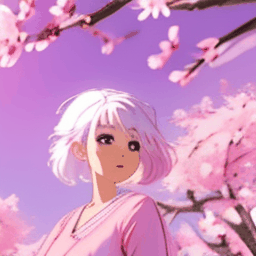

In [70]:

gif = next(
    p.predict(
        prompt="masterpiece, best quality, 1girl, solo, cherry blossoms, hanami, pink flower, white flower, spring season, wisteria, petals, flower, plum blossoms, outdoors, falling petals, white hair, black eyes",
        negative_prompt="badhandv4,easynegative,ng_deepnegative_v1_75t,verybadimagenegative_v1.3, bad-artist, bad_prompt_version2-neg, teeth",
        base_model="toonyou_beta3",
        zoom_in_alpha=0.2,
        zoom_out_alpha=0.0,
        pan_left_alpha=0.3,
        pan_right_alpha=0.0,
        pan_up_alpha=0.5,
        pan_down_alpha=0.0,
        rolling_clockwise_alpha=0.0,
        rolling_anticlockwise_alpha=0.0,
        steps=50,
        guidance_scale=7.5,
        frames=16,
        width=256,
        height=256,
        seed=1337
    )
)


from IPython.display import display, Image

# Display the image
print(gif)
display(Image(filename=str(gif)))



___

In [ ]:
# Define the variables
zoom_in_alpha = 0.2
zoom_out_alpha = 0.0
pan_left_alpha = 0.3
pan_right_alpha = 0.0
pan_up_alpha = 0.5
pan_down_alpha = 0.0
rolling_clockwise_alpha = 0.0
rolling_anticlockwise_alpha = 0.0
steps = 50
guidance_scale = 7.5
seed = 1337
prompt = "masterpiece, best quality, 1girl, solo, cherry blossoms, hanami, pink flower, white flower, spring season, wisteria, petals, flower, plum blossoms, outdoors, falling petals, white hair, black eyes"
negative_prompt = "badhandv4,easynegative,ng_deepnegative_v1_75t,verybadimagenegative_v1.3, bad-artist, bad_prompt_version2-neg, teeth"

# Rest of the code
base_model = "realisticVisionV20_v20"
lora_model_path = ""
motion_module_type = "mm_sd_v15_v2"
pretrained_model_path = "models/StableDiffusion/stable-diffusion-v1-5"
inference_config_path = "configs/inference/inference-v2.yaml"
motion_module = f"models/Motion_Module/{motion_module_type}.ckpt"
dreambooth_path = f"models/DreamBooth_LoRA/{base_model}.safetensors"

motion_strengths = {
    'ZoomIn': zoom_in_alpha,
    'ZoomOut': zoom_out_alpha,
    'PanLeft': pan_left_alpha,
    'PanRight': pan_right_alpha,
    'PanUp': pan_up_alpha,
    'PanDown': pan_down_alpha,
    'RollingAnticlockwise': rolling_anticlockwise_alpha,
    'RollingClockwise': rolling_clockwise_alpha
}

MOTION_MODULE_LORA_CONFIG_TEMPLATE = """
- path:  "models/MotionLoRA/v2_lora_{motion_lora_type}.ckpt"
  alpha: {motion_lora_strength}
"""

motion_module_lora_configs = ''
for motion_lora_type, motion_lora_strength in motion_strengths.items():
    if motion_lora_strength != 0:
        motion_module_lora_configs += MOTION_MODULE_LORA_CONFIG_TEMPLATE.format(motion_lora_type=motion_lora_type, motion_lora_strength=motion_lora_strength)

motion_module_lora_configs_section = f"motion_module_lora_configs:{motion_module_lora_configs}" if motion_module_lora_configs else ''

config = FAKE_YAML_TEMPLATE.format(
    inference_config=inference_config_path,
    motion_module=motion_module,
    motion_module_lora_configs_section=motion_module_lora_configs_section,
    dreambooth_path=dreambooth_path,
    lora_model_path=lora_model_path,
    seed=seed,
    steps=steps,
    guidance_scale=guidance_scale,
    prompt=prompt,
    negative_prompt=negative_prompt,
)
print(config)

: 